In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsTransformer
from scipy.sparse.csgraph import csgraph_to_masked
from sklearn.metrics import adjusted_rand_score
from sknetwork.clustering import Louvain,get_modularity
from sknetwork.data import from_adjacency_list
import networkx as nx
import anndata as ad
import scanpy as sc
import sys
sys.path.append('/home/bili/Lernen/ProjectsComBio')
from model.utils import ricciCurvature
%matplotlib inline

/home/bili/Apps/Mamba/envs/cb/lib/python3.11/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Sample from the grid
np.random.seed(0)
x = np.linspace(-1.5, 1.5, 200)
y = np.linspace(-1.5,1.5,200)
xx, yy = np.meshgrid(x,y)
f = lambda x: 0.5*(x[:,0]**2-1)**2 + 0.5*(x[:,1]**2-1)**2+0.01
points = np.vstack([xx.ravel(),yy.ravel()]).T
dist = f(points).ravel()
norm_dist = (1/dist)/np.sum(1/dist)
sample_index = np.random.choice(points.shape[0], 1000, p=norm_dist)
sampled_points = points[sample_index]
point_height = f(sampled_points)
point_data = np.hstack([sampled_points,point_height.reshape(-1,1)])
knn_graph = KNeighborsTransformer(n_neighbors=30, mode='distance').fit_transform(point_data)
small_knn_graph = KNeighborsTransformer(n_neighbors=10, mode='distance').fit_transform(point_data)

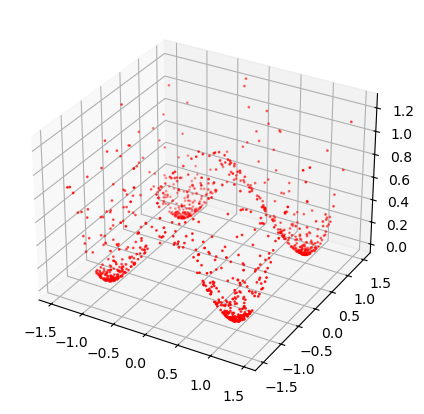

In [26]:
# Plot the samples and original function
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111,projection='3d')
#plt.scatter(x, y, c='r', s=1)
point_height = f(sampled_points)
#ax.plot_surface(sampled_points[:,0],sampled_points[:,1],point_height,color='b',alpha=0.1)
ax.scatter(sampled_points[:,0],sampled_points[:,1],point_height, c='r', s=1)
# selective anchor points 
plt.show()

In [4]:
curvature = ricciCurvature(point_data,knn_graph)

In [5]:
# select indices on knn graph with the highest curvature
graph_mask = csgraph_to_masked(knn_graph)
curvature_masked = graph_mask * curvature
max_curv_indicies = np.argsort(np.abs(curvature_masked), axis=1)[:,:10]
min_curv_indicies = np.argsort(np.abs(curvature_masked), axis=1)[:,20:30]
max_curv_graph = sp.sparse.csr_matrix(knn_graph.shape)
min_curv_graph = sp.sparse.csr_matrix(knn_graph.shape)
for i in range(max_curv_indicies.shape[0]):
    max_curv_graph[i,max_curv_indicies[i]] = knn_graph[i,max_curv_indicies[i]]
    min_curv_graph[i,min_curv_indicies[i]] = knn_graph[i,min_curv_indicies[i]]
    

/home/bili/Apps/Mamba/envs/cb/lib/python3.11/site-packages/scipy/sparse/_index.py:137: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


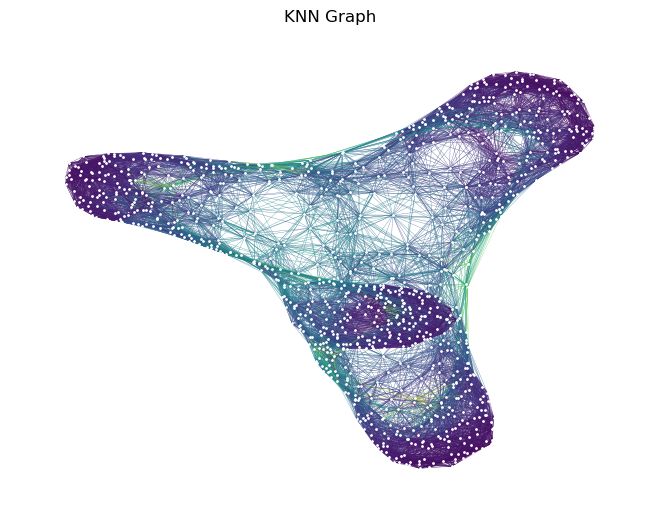

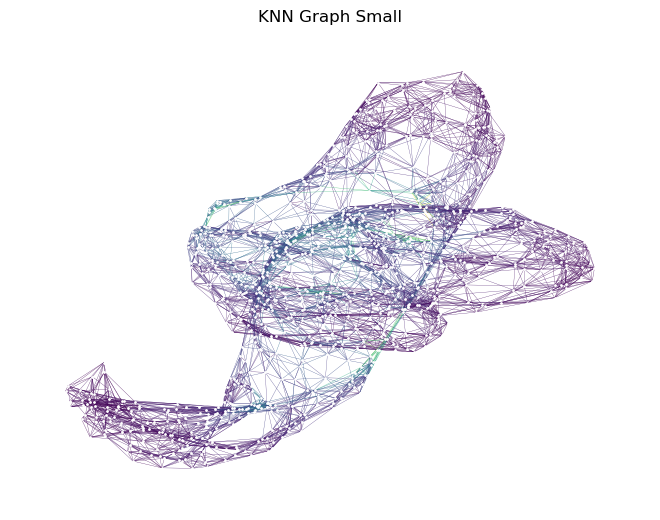

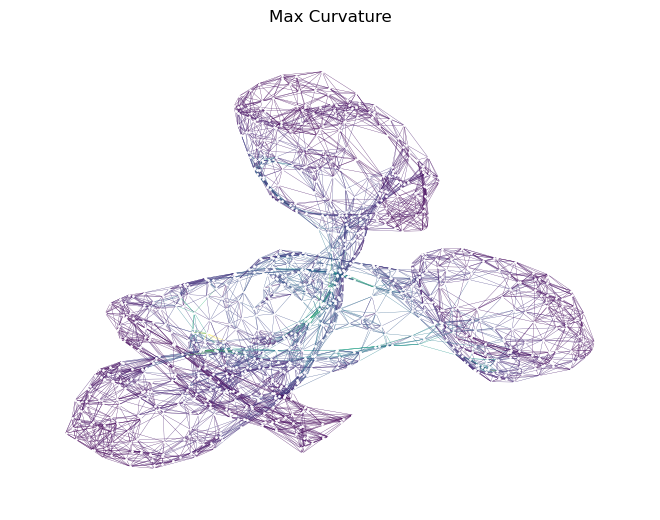

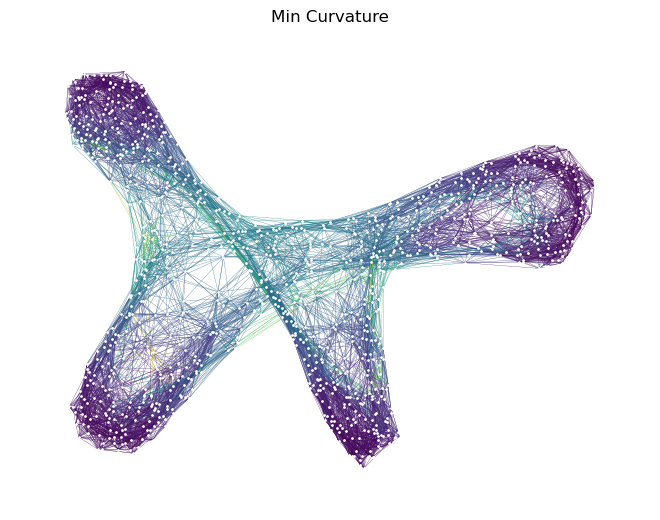

In [6]:
import networkx as nx
def drawGraph(adj):
    graph = nx.from_numpy_array(adj)
    edge_value = nx.get_edge_attributes(graph,'weight')
    edge_value = edge_value.values()
    nx.draw(graph,node_color='white',node_size=1,width=0.2,edge_color=edge_value,edge_cmap=plt.cm.viridis)
    return
for graph,title in zip([knn_graph,small_knn_graph,max_curv_graph,min_curv_graph],["KNN Graph","KNN Graph Small","Max Curvature","Min Curvature"]):
    drawGraph(graph)
    plt.title(title)
    plt.show()

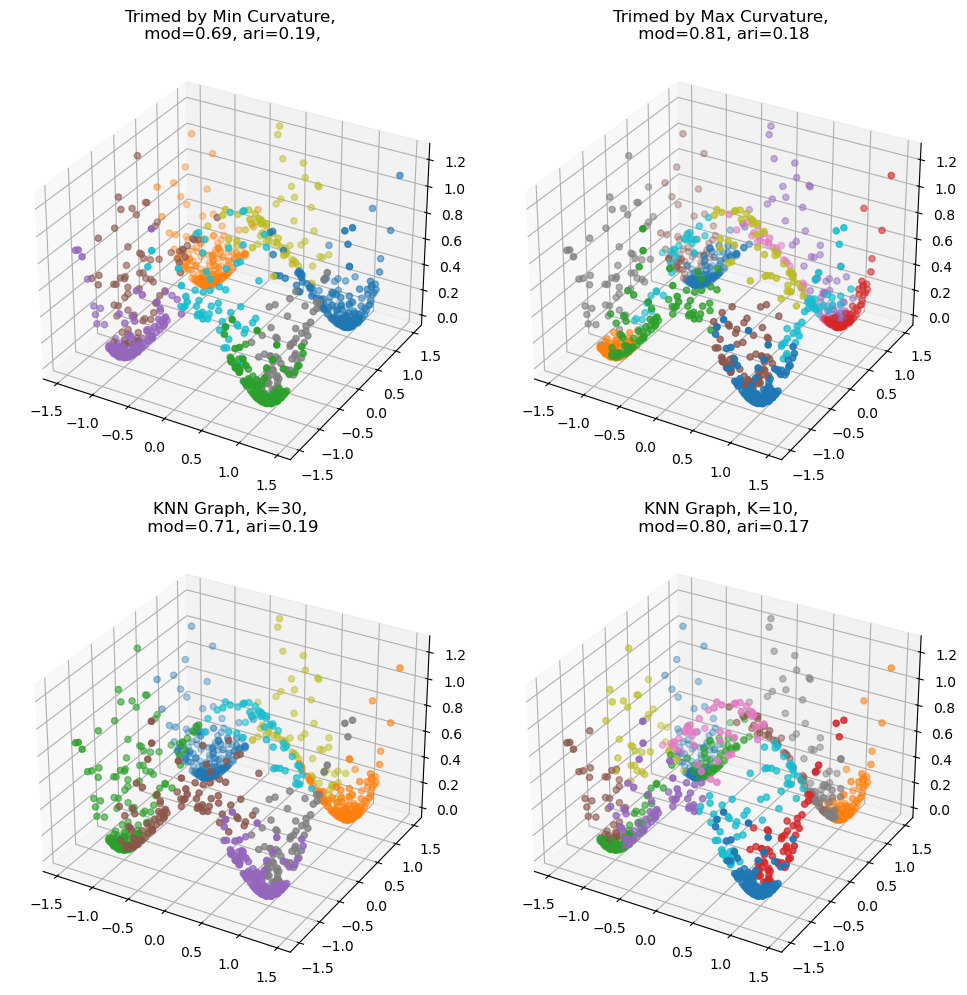

In [24]:
true_labels = [np.floor(x).sum() for x in sampled_points]
louvain = Louvain(resolution=1)
labels_min = louvain.fit_predict(min_curv_graph)
labels_max = louvain.fit_predict(max_curv_graph)
labels_knn = louvain.fit_predict(knn_graph)
labels_knn_small = louvain.fit_predict(small_knn_graph)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(221,projection='3d')
ax.scatter(sampled_points[:,0],sampled_points[:,1],point_height,c=labels_min,cmap='tab10')
ax.set_title('Trimed by Min Curvature,\n mod={:.2f}, ari={:.2f},'.format(get_modularity(min_curv_graph,labels_min),adjusted_rand_score(true_labels,labels_min)))
ax = fig.add_subplot(222,projection='3d')
ax.scatter(sampled_points[:,0],sampled_points[:,1],point_height,c=labels_max,cmap='tab10')
ax.set_title('Trimed by Max Curvature,\n mod={:.2f}, ari={:.2f}'.format(get_modularity(max_curv_graph,labels_max),adjusted_rand_score(true_labels,labels_max)))
ax = fig.add_subplot(223,projection='3d')
ax.scatter(sampled_points[:,0],sampled_points[:,1],point_height,c=labels_knn,cmap='tab10')
ax.set_title('KNN Graph, K=30,\n mod={:.2f}, ari={:.2f}'.format(get_modularity(knn_graph,labels_knn),adjusted_rand_score(true_labels,labels_knn)))
ax = fig.add_subplot(224,projection='3d')
ax.scatter(sampled_points[:,0],sampled_points[:,1],point_height,c=labels_knn_small,cmap='tab10')
ax.set_title('KNN Graph, K=10,\n mod={:.2f}, ari={:.2f}'.format(get_modularity(small_knn_graph,labels_knn_small),adjusted_rand_score(true_labels,labels_knn_small)))
fig.tight_layout()
plt.show()